# Prepare the Excels for the reannotation of a subset of the dataset
Documentation & code to create the Excels used for the reannotation of the dataset.

In [5]:
__import__('sys').path.append('../common'); __import__('notebook_utils').table_of_contents('prepare_reannotation_Excels.ipynb')

<h3>Table of contents</h3>


[Prepare the Excels for the reannotation of a subset of the dataset](#Prepare-the-Excels-for-the-reannotation-of-a-subset-of-the-dataset)
- [Explanation](#Explanation)
- [Setup & load data](#Setup-&-load-data)
- [Compare original and revised datasets](#Compare-original-and-revised-datasets)
  - [Comparison of the worst predicted sentences (threshold=0.2) between the different iterations](#Comparison-of-the-worst-predicted-sentences-(threshold=0.2)-between-the-different-iterations)
- [Prepare 2nd | 3rd iterations datasets to reannotate](#Prepare-2nd-|-3rd-iterations-datasets-to-reannotate)
- [Prepare 1st iteration to reannotate (raw dataset)](#Prepare-1st-iteration-to-reannotate-(raw-dataset))
  - [Get worst predictions](#Get-worst-predictions)
  - [Get the joined sentences](#Get-the-joined-sentences)
  - [Get duplicated sentences](#Get-duplicated-sentences)
  - [Save them in a csv format](#Save-them-in-a-csv-format)
- [Excel VBA script](#Excel-VBA-script)

## Explanation

In [6]:
# TODO - "See Classifiers_training/README.md --> Ensure it is explained there

This notebook contains the code used to create Excels with sentences from the training dataset to be re-checked by the annotators. 

To select these sentences, several TRI and MoR classifiers were trained on the training dataset using 5-fold cross-validation (see `../../classifiers_training/README.md`). Each model was saved in its own folder, containing the `train_parameters.json` file with all parameters used for training. Within the file, `report_df` contains, for each fold, the validation metrics (accuracy, f1-score, recall, precision) as well as the prediction scores given to each sentence in the validation folds along with the correct label. See one example below

In [7]:
# Show an example of report_df
MAIN_FOLDER = '../../classifiers_training/saved_models/'
import json
for classifier_type in ['TRI', 'MoR']:
    with open(MAIN_FOLDER + f'{classifier_type}_classifier/BioBERT_5e_lr3e-05/train_params.json', 'r') as f:
        train_params = json.load(f)

    print(f"Report_df contents for the first fold for the {classifier_type} classifiers:")
    for k, v in train_params['report_df'].items():
        print(f"{k:<20} {v[:1]+['...'] if isinstance(v, list) else v}")
    print("\n")

Report_df contents for the first fold for the TRI classifiers:
fold                 [1, '...']
accuracy             [0.93206, '...']
f1_score             [0.93744, '...']
recall               [0.95139, '...']
precision            [0.92389, '...']
auroc                [0.97619, '...']
confusion            [[[1594, 158], [98, 1918]], '...']
probabilities        [[0.0007090524886734784, 0.001618740032427013, 0.9877309203147888, 0.000715641479473561, 0.9089997410774231, 0.9717864990234375, 0.8791311383247375, 0.9770914912223816, 0.0010625163558870554, 0.4950794279575348, 0.9910339713096619, 0.0005955671076662838, 0.04731997847557068, 0.0006385259330272675, 0.0011124552693217993, 0.9908581376075745, 0.026507899165153503, 0.989997923374176, 0.9879851937294006, 0.9859452843666077, 0.0023935099598020315, 0.002613419434055686, 0.9875707626342773, 0.989092230796814, 0.9915326237678528, 0.0007503364467993379, 0.001360185444355011, 0.004812768194824457, 0.9721794724464417, 0.002609577728435397, 0.

All models are saved within the folder `../../classifiers_training/saved_models/`, which has the following structure:
* `TRI_classifier/`
  * `before_1st_validation/`
    * `BioLinkBERT_5e/`
    * ...
  * `before_2nd_validation/`
  * `before_3rd_validation/`
  * `BioLinkBERT_5e/`
  * ...
* `MoR_classifier/`  
  * ...

Validation metrics are used to compare different models and select the best-performing one (see `analysis/classifiers_comparison`), while the model predictions are used in this notebook to extract those sentences whose model prediction is farthest from its label. Those sentences are combined for the 5 validation folds in one Excel, which is sent to the annotators to re-check.

This way, the training dataset has gone through 3 reannotation iterations, which are detailed below.

Below, the scripts used to identify the best-performing model, graphics with the results, and creation of the Excel with worst-predicted sentences.

In [8]:
# TODO - Explain somewhere that saved_models / final_models has been re-trained.. how did I do it?
# 1. 5-fold cross-validation without train-test set
# 2. Get the worst performing sentences from the best-performing model
# 3. Repeat that for 3 iterations
# 4. For the final iteration, 1st separate in test-train, then do 5-fold, then finally train on all data 

## Setup & load data

In [9]:
# IMPORTS
# Display
from IPython.display import display, HTML, display_html
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns
from sklearn.metrics import precision_recall_curve

# Basics
import numpy as np
import pandas as pd
import os
import json

# NER
import spacy
import re

# My functions
import sys
sys.path.append('../common/') 
from notebook_utils import h3, h4, h5, md

pd.set_option('display.max_colwidth', 1000)

In [10]:
## PATHS
# Folders
MODELS_PATH = '../../classifiers_training/saved_models/'
TRI_path = MODELS_PATH + 'TRI_classifier/'
MoR_path = MODELS_PATH + 'MoR_classifier/'

raw_data_path =         '../../data/external/original_tri_sentences.tsv'
training_data_path =    '../../classifiers_training/data/tri_sentences.tsv'

# BEST PERFORMING MODELS
# Before 1st iteration
iter0_TRI_path = TRI_path + 'before_1st_validation/BioLinkBERT_5e_lr3e-05/train_params.json'
iter0_MoR_path = MoR_path + 'before_1st_validation/BioLinkBERT_5e_lr3e-05/train_params.json'
# Before 2nd iteration
iter1_TRI_path = TRI_path + 'before_2nd_validation/BioLinkBERT_5e_lr3e-05/train_params.json'
iter1_MoR_path = MoR_path + 'before_2nd_validation/BioLinkBERT_5e_lr3e-05/train_params.json'
# Before 3rd iteration
iter2_TRI_path = TRI_path + 'before_3rd_validation/BioLinkBERT_5e_lr3e-05/train_params.json'
iter2_MoR_path = MoR_path + 'before_3rd_validation/BioLinkBERT_5e_lr3e-05/train_params.json'

# Before 4th iteration
iter3_TRI_path = TRI_path + 'BioLinkBERT_span_5e_lr3e-05/train_params.json'
iter3_MoR_path = MoR_path + 'BioLinkBERT_span_5e_lr3e-05/train_params.json'


# Sentences to reannotate
to_reannotate_folder = '../../data/dataset_improvement/'
iter3_reannotate_path = to_reannotate_folder + 'iter3_04_17_worst_preds.tsv'
iter2_reannotate_path = to_reannotate_folder + 'iter2_03_28_worst_preds.tsv'
iter1_reannotate_path = to_reannotate_folder + 'iter1_03_08_worst_preds.tsv'

In [11]:
# LOAD PARAMS
def load_params(file_path):
    with open(file_path) as json_file:
        return json.load(json_file)

iter3_TRI_params = load_params(iter3_TRI_path)
iter3_MoR_params = load_params(iter3_MoR_path)

iter1_2_TRI_params = load_params(iter2_TRI_path)
iter1_2_MoR_params = load_params(iter2_MoR_path)

iter1_TRI_params = load_params(iter1_TRI_path)
iter1_MoR_params = load_params(iter1_MoR_path)

iter0_TRI_params = load_params(iter0_TRI_path)
iter0_MoR_params = load_params(iter0_MoR_path)

# LOAD DATASETS
# Get the raw data (we'll need to remove the duplicates from there again)
raw_data = pd.read_csv(raw_data_path, sep='\t', header=1)
# Revised data (data that is now used to train the model)
training_data = pd.read_csv(training_data_path, sep='\t', header=0, index_col=0)


## Compare original and revised datasets

The plots shown below show the distribution of predictions for the true label for TRI and MoR, and for the revised and original dataset. It can be observed that **the revised dataset has a slightly improved density distribution of predictions**: there are more predictions nearing 1, and less nearning 0.

In [12]:
# CREATE DATAFRAMES
threshold = 0.2  # Probability threshold

# Initialize empty DataFrames for the metrics
categories = ['TRI', 'MoR', 'UNDEF', 'ACTIV', 'REPR']
metrics = ['accuracy', 'f1_score', 'recall', 'precision']
metrics_dfs = {}
preds_dfs = {}
wrong_sentences_count = {}

for TRI_params, MoR_params, heading in [(iter3_TRI_params, iter3_MoR_params, "Iter 3 data"),
                                        (iter1_2_TRI_params, iter1_2_MoR_params, "Iter 2 data"),
                                        (iter1_TRI_params, iter1_MoR_params, "Iter 1 data"),
                                        (iter0_TRI_params, iter0_MoR_params, "Original data")]:   
    for params, txt in [(TRI_params, 'TRI'), (MoR_params, 'MoR')]:
        # Create a df with the predictions from the params_json file
        # by flattening the list for each column
        columns = ['probabilities', 'labels', 'val_texts']
        preds_dict = {column: [item for sublist in params['report_df'][column] for item in sublist] for column in columns}
        preds_df = pd.DataFrame(preds_dict)

        # Create column with the probability of the correct label
        if txt == 'TRI':
            preds_df['pred_prob'] = (preds_df['labels'] - preds_df['probabilities']).apply(lambda x: 1 - abs(x))
            preds_df['TRUE'] = preds_df['probabilities']
            preds_df['FALSE'] = 1 - preds_df['probabilities']
            TRI_df = preds_df.sort_values(by='pred_prob', ascending=False)
        elif txt == 'MoR':
            preds_df['pred_prob'] = preds_df.apply(lambda row: row['probabilities'][row['labels']], axis=1)
            preds_df['UNDEFINED'] = preds_df.apply(lambda row: row['probabilities'][0], axis=1)
            preds_df['ACTIVATION'] = preds_df.apply(lambda row: row['probabilities'][1], axis=1)
            preds_df['REPRESSION'] = preds_df.apply(lambda row: row['probabilities'][2], axis=1)
            MoR_df = preds_df.sort_values(by='pred_prob', ascending=False)
        
    # Save created dataframes in a dictionary
    preds_dfs[heading] = {'TRI': TRI_df, 'MoR': MoR_df}
        
    # CREATE METRICS DATAFRAMES 
    data = []
    for m in metrics:
        TRI = sum(TRI_params['report_df'][m])/5
        UNDEF, ACTIV, REPR = [sum(MoR_params['report_df'][m][i][j] for i in range(5))/5 for j in range(3)]
        MoR = sum([UNDEF, ACTIV, REPR])/3
        # Collect each row's data in a list
        data.append([TRI, MoR, UNDEF, ACTIV, REPR])

    # Save the collected dataframe in metrics_dfs
    metrics_dfs[heading] = pd.DataFrame(data, columns=categories, index=metrics)

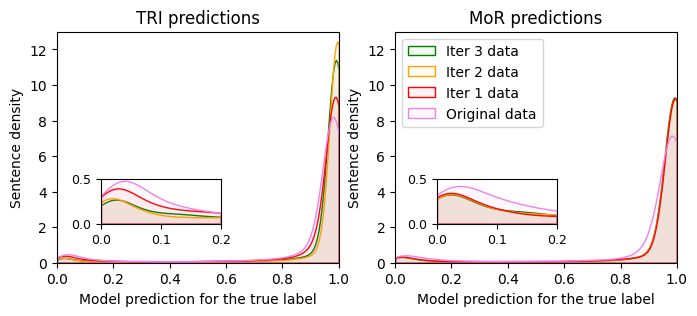

<h4>Predictions for the true label. Ideally, there should only be one peak at prediction=1. The revised data is closer to this ideal, with ahigher peak at around 1, and a smaller peak at around 0.</h4>

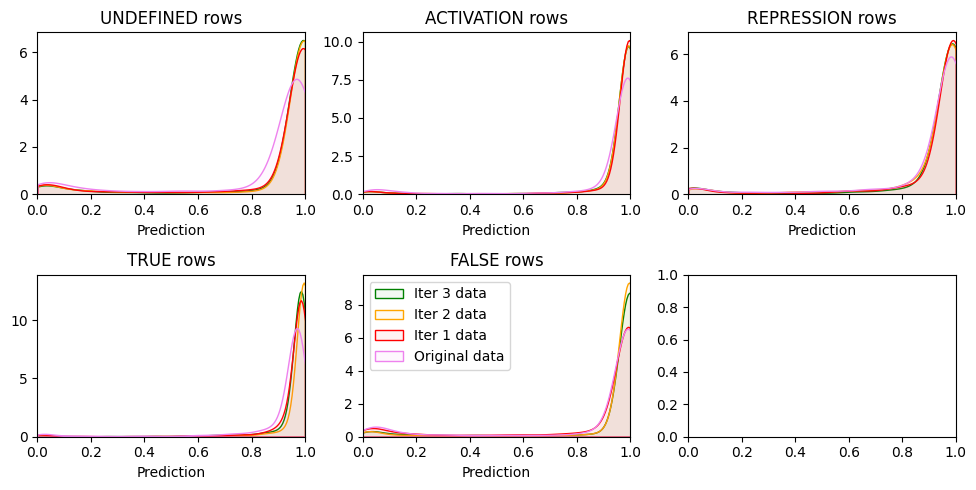

<h4>Predictions for the true label. Ideally, there should only be one peak at prediction=1. The revised data is closer to this ideal, with ahigher peak at around 1, and a smaller peak at around 0.</h4>

In [13]:
# DISPLAY KDEPLOTS
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

## TRI & MoR
# Define position of inline plots: 
# [left, bottom, width, height]
inlines = {
    'TRI': fig.add_axes([0.18, 0.24, 0.15, 0.15]),
    'MoR': fig.add_axes([0.60, 0.24, 0.15, 0.15]),
}

alpha = 0.05
colors = ['green', 'orange', 'red', 'violet']

for (data_type, dfs), color in zip(preds_dfs.items(), colors):
    for i, (txt, preds_df) in enumerate(dfs.items()):
        # Create density plot
        ax = axs[i]
        ax.set_title(f'{txt} predictions')
        sns.kdeplot(preds_df['pred_prob'], fill=True, alpha=alpha, clip=[0,1], ax=ax, label=data_type, color=color)
        ax.set(xlim=(0, 1), ylim=(0, 13))
        ax.set_xlabel('Model prediction for the true label')
        ax.set_ylabel('Sentence density')

        sns.kdeplot(preds_df['pred_prob'], fill=True, alpha=alpha, clip=[0,threshold], ax=inlines[txt], color=color)

#Clean inline axes
for inline_ax in inlines.values():
    inline_ax.set(xlim=(0, threshold), ylim=(0,0.5))
    inline_ax.set_xlabel('')
    inline_ax.set_ylabel('')
    inline_ax.tick_params(axis='both', labelsize=9)

ax.legend()
plt.show()
h4('Predictions for the true label. Ideally, there should only be one peak at prediction=1. The revised data is closer to this ideal, with a\
higher peak at around 1, and a smaller peak at around 0.')


# TRI & MoR disglossed in histograms
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = [ax for row in axs for ax in row]
# Define position of inline plots:
inlines = {
    'UNDEFINED':  ('MoR', 0),
    'ACTIVATION': ('MoR', 1),
    'REPRESSION': ('MoR', 2),
    'TRUE':       ('TRI', 1),
    'FALSE':      ('TRI', 0),
}

for color, (data_type, dfs) in zip(colors, preds_dfs.items()):
    for i, (label_name, (txt, label)) in enumerate(inlines.items()):
        # Create density plot
        df = dfs[txt]
        df = df[df['labels'] == label]
        ax = axs[i]
        ax.set_title(f'{label_name} rows')
        #sns.histplot(df[label_name], fill=False, ax=ax, label=data_type, bins=10, element='step', kde=True)
        sns.kdeplot(df[label_name], fill=True, alpha=alpha, clip=[0,1], ax=ax, label=data_type, color=color)
        ax.set_ylabel('')
        ax.set_xlabel('Prediction')
        ax.set(xlim=(0, 1))

ax.legend()
plt.tight_layout()
plt.show()
h4('Predictions for the true label. Ideally, there should only be one peak at prediction=1. The revised data is closer to this ideal, with a\
higher peak at around 1, and a smaller peak at around 0.')

By comparing the metrics of the two methods, we can see how much the validated dataset has improved the results:

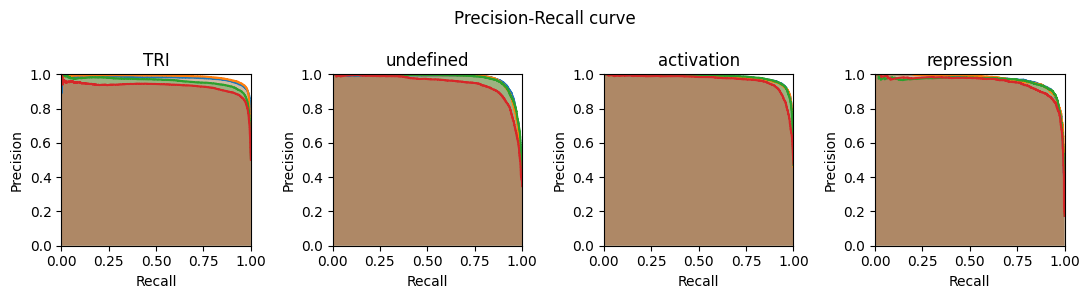

In [14]:
# DISPLAY PRECISION-RECALL CURVE
#from sklearn.metrics import precision_recall_curve
pd.options.display.float_format = "{:,.3f}".format
fig, axs = plt.subplots(1, 4, figsize=(11, 3))
plt.suptitle("Precision-Recall curve")

def plot_precision_recall(probas_pred, true_labels, ax, title):
    precision, recall, thresholds = precision_recall_curve(true_labels, probas_pred, pos_label=1)
    ax.plot(recall, precision)
    ax.fill_between(recall, precision, alpha=0.3)
    ax.set(ylim=(0, 1), xlim=(0, 1))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)

for data_type in preds_dfs.keys():
    # TRI
    preds_df = preds_dfs[data_type]['TRI']
    probas_pred = preds_df['probabilities']
    true_labels = preds_df['labels']
    plot_precision_recall(probas_pred, true_labels, axs[0], 'TRI')
    
    # MoR
    preds_df = preds_dfs[data_type]['MoR']
    MoR_labels = ['undefined', 'activation', 'repression']
    for idx in range(3):
        probas_pred = preds_df.apply(lambda row: row['probabilities'][idx], axis=1)
        true_labels = preds_df.apply(lambda row: 1 if row['labels'] == idx else 0, axis=1)
        plot_precision_recall(probas_pred, true_labels, axs[idx+1], MoR_labels[idx])

plt.tight_layout()
plt.show()

In [15]:
# DISPLAY METRICS DATAFRAMES
revised_df_metrics = metrics_dfs['Iter 3 data']
original_df_metrics = metrics_dfs['Original data']
difference_df_metrics = revised_df_metrics - original_df_metrics

#############
## MARKDOWN
h4('Comparison of the metrics between the two datasets')
md(f"Revising **{len(training_data[training_data['validated?'] == True])/len(training_data):.1%}** of the dataset has led to \
an improvement of the **f1_score** of \
**{difference_df_metrics['TRI']['f1_score']:.1%}** for the TRI classifier and \
**{difference_df_metrics['MoR']['f1_score']:.1%}** for the MoR classifier.")

# Style the DataFrames and display them side by side
original_styler   = original_df_metrics.style.format("{:.2f}").set_table_attributes("style='display:inline'").set_caption('<b>Original data</b>')
revised_styler    = revised_df_metrics.style.format("{:.2f}").set_table_attributes("style='display:inline'").set_caption('<b>Revised data</b>')
difference_styler = difference_df_metrics.style.format("{:+.2f}").set_table_attributes("style='display:inline'").set_caption('<b>Difference</b>')
display_html(original_styler._repr_html_() + revised_styler._repr_html_() + difference_styler._repr_html_(), raw=True)
#############

<h4>Comparison of the metrics between the two datasets</h4>

Revising **14.1%** of the dataset has led to an improvement of the **f1_score** of **3.8%** for the TRI classifier and **3.2%** for the MoR classifier.

,TRI,MoR,UNDEF,ACTIV,REPR
accuracy,0.90,0.90,0.86,0.92,0.93
f1_score,0.91,0.90,0.88,0.92,0.89
recall,0.94,0.90,0.86,0.92,0.93
precision,0.87,0.89,0.91,0.91,0.87
,TRI,MoR,UNDEF,ACTIV,REPR
accuracy,0.94,0.93,0.90,0.95,0.94
f1_score,0.95,0.93,0.93,0.94,0.92
recall,0.96,0.93,0.90,0.95,0.94
precision,0.93,0.93,0.95,0.93,0.90
,TRI,MoR,UNDEF,ACTIV,REPR


### Comparison of the worst predicted sentences (threshold=0.2) between the different iterations
The following table and venn diagrams compares the "worstly predicted" sentences from the original dataset and the revised dataset.

In [16]:
# COUNT NUMBER OF ROWS BELOW THRESHOLD
# Show difference of sentences between the revised and original cases
# b_t = below_threshold
threshold = 0.2
b_t_counts = {key :[] for key in preds_dfs.keys()} 
for key, dfs in preds_dfs.items():
    TRI_df, MoR_df = dfs['TRI'], dfs['MoR']
    TRI_b_t_df = TRI_df[TRI_df["pred_prob"] < threshold]
    MoR_b_t_df = MoR_df[MoR_df["pred_prob"] < threshold]
    num_unique_b_t = len(pd.concat([MoR_b_t_df['val_texts'],TRI_b_t_df['val_texts']]).unique())

    b_t_counts[key] = [len(TRI_b_t_df), len(TRI_b_t_df) / len(TRI_df),
                       len(MoR_b_t_df), len(MoR_b_t_df) / len(MoR_df),
                       num_unique_b_t, num_unique_b_t/len(raw_data)]

ws = pd.DataFrame(b_t_counts, index=['TRI', '%', 'MoR', '%', 'Combined', '%'])
ws['Difference'] = ws['Iter 3 data'] - ws['Original data']

h4(f'Comparison table: number of sentences below the threshold {threshold} in each category\n')
pd.options.display.float_format = "{:,.2%}".format
display(ws.T.astype({col: 'int32' for col in ['TRI', 'MoR', 'Combined']}))

<h4>Comparison table: number of sentences below the threshold 0.2 in each category
</h4>

,TRI,%,MoR,%,Combined,%
Iter 3 data,674,3.58%,487,4.90%,1124,5.08%
Iter 2 data,734,3.40%,553,4.83%,1265,5.71%
Iter 1 data,1203,5.57%,543,4.92%,1707,7.71%
Original data,1454,6.74%,763,7.06%,2158,9.75%
Difference,-780,-3.16%,-276,-2.16%,-1034,-4.67%


<h4>Venn diagrams</h4>

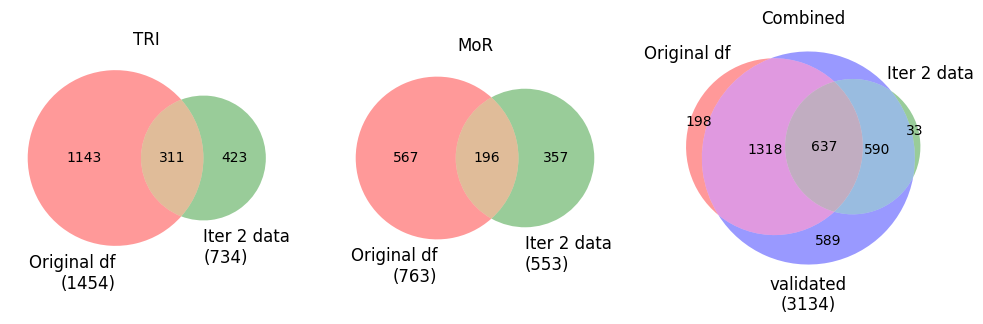

<h4><i>Figure X. Comparison of the sentences below the threshold of 0.2 between training the model with the original dataset and the revised dataset</i></h4>


From the venn diagram, we can make some observations on the revised dataset to predict.
It contains:
* **38 sentences** to be revised (wrongly predicted by the model and not revised yet).
* **33 new 'wrongly predicted' sentences**.
* **198 sentences excluded** from the original dataset, that hadn't been revised yet.
* **39% of the validated sentences** (1227), which will be excluded in the new excel.


In [17]:
### VENN DIAGRAMS - Comparison of original DF with last DF
# Convert pd.Series into sets to compare them. 
# This method would be incorrect if there were duplicated sentences. We can make sure there are none, as the numbers on the table above
# all coincide with the numbers of the sets in the venn diagrams below.
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
h4('Venn diagrams')

# GET THE LAST ITERATION
last_iter = 'Iter 2 data'
# Worst sentences sets
ws_sets = {}
for idx, txt in enumerate(['TRI', 'MoR']):
    # Get dataframes
    df_orig = preds_dfs['Original data'][txt]
    df_rev  = preds_dfs[last_iter][txt]

    # Create sets and save them to ws_sets dict
    ws_orig_set = set(df_orig[df_orig['pred_prob']<threshold]['val_texts'])
    ws_rev_set  = set(df_rev[df_rev['pred_prob']<threshold]['val_texts'])
    ws_sets[txt] = {'orig': ws_orig_set, 'rev': ws_rev_set}

    # Plot venn diagram comparing original_df to revised_df
    axs[idx].set_title(txt)
    venn2([ws_orig_set, ws_rev_set], set_labels=([f'Original df\n({len(ws_orig_set)})', f'{last_iter}\n({len(ws_rev_set)})']), ax=axs[idx])


# COMPARISON FINAL AND ORIGINAL DATASET
# Prepare sets
orig_set = ws_sets['TRI']['orig'].union(ws_sets['MoR']['orig'])
revised_set = ws_sets['TRI']['rev'].union(ws_sets['MoR']['rev'])
val_set = set(training_data[training_data['validated?'] == True]['Sentence'])#.intersection(orig_set)

# Plot venn diagram
#plt.figure(figsize=(4, 4))
axs[2].set_title('Combined')
#plt.tick_params(axis='both', labelsize=30) # Not working
venn3([orig_set, revised_set, val_set], set_labels=(['Original df', last_iter, f'validated\n({len(val_set)})']), ax=axs[2])
plt.show()
h4(f'<i>Figure X. Comparison of the sentences below the threshold of {threshold} between training the model with the original dataset and the revised dataset</i>')
md(f'''
From the venn diagram, we can make some observations on the revised dataset to predict.
It contains:
* **{len(revised_set - val_set)} sentences** to be revised (wrongly predicted by the model and not revised yet).
* **{len(revised_set - orig_set - val_set)} new 'wrongly predicted' sentences**.
* **{len(orig_set - revised_set - val_set)} sentences excluded** from the original dataset, that hadn't been revised yet.
* **{len(val_set & revised_set)/len(val_set):.0%} of the validated sentences** ({len(val_set & revised_set)}), which will be excluded in the new excel.
''')

## Prepare 2nd | 3rd iterations datasets to reannotate

In [18]:
# Decide which iteration:
iter_num = 3    # 2 or 3

def prepare_reannotation_dataset(training_data: pd.DataFrame, preds_dfs: dict, iter_num: int, filepath: str, threshold: float = 0.2):
    '''
    training_data:  dataset used to train in the previous iteration.
    iter_num:       Number of the incoming iteration
    '''

    TRI_df = preds_dfs[f'Iter {iter_num-1} data']['TRI']
    MoR_df = preds_dfs[f'Iter {iter_num-1} data']['MoR']

    # Merge TRI, MoR predictions dataset with the revised dataset (the one used in the previous iteration for training) 
    merged_data = pd.merge(training_data, TRI_df[['val_texts', 'pred_prob', 'probabilities']], how='inner', right_on='val_texts', left_on='Sentence').drop(columns='val_texts')
    merged_data = pd.merge(merged_data, MoR_df[['val_texts', 'pred_prob', 'probabilities']],  how='left',  right_on='val_texts', left_on='Sentence', suffixes = ('_TRI', '_MoR')).drop(columns='val_texts')

    # Get unique rows with prediction below certain threshold
    worst_TRIs = merged_data[merged_data['pred_prob_TRI'] < threshold]
    worst_MoRs = merged_data[merged_data['pred_prob_MoR'] < threshold]

    # Merge TRI & MoR and drop duplicates (those with the same sentence)
    worst_preds = pd.concat([worst_TRIs, worst_MoRs]).drop_duplicates(subset=['Sentence'], keep='first')
    worst_preds = worst_preds.sort_values(by=['Label', 'pred_prob_TRI', 'Type', 'pred_prob_MoR'])

    # Discard validated ones
    worst_preds = worst_preds[worst_preds['validated?'] == False]
    worst_preds = worst_preds.drop(columns='validated?')

    # Prepare columns for Excel by reordering & renaming them
    ordered_columns = ['#TRI ID', 'TF_norm', 'TG_norm', 'TF', 'TG', 'Sentence', 'Label', 'MoR', 'pred_prob_TRI', 'pred_prob_MoR']
    worst_preds = worst_preds.assign(TF_norm=worst_preds['#TRI ID'].str.split(':').str[2])
    worst_preds = worst_preds.assign(TG_norm=worst_preds['#TRI ID'].str.split(':').str[3])
    worst_preds = worst_preds.rename(columns={'Type': 'MoR'})
    worst_preds = worst_preds[ordered_columns]
    worst_preds = worst_preds.set_index('#TRI ID')

    md(f'We add up together TRI and MoR sentences with a prediction < {threshold}, and remove the already validated sentences, getting {len(worst_preds)} rows.<br>Display of 3 rows:')
    display(worst_preds[:3])

    worst_preds.to_csv(filepath, sep='\t')
    md(f'The new tsv of the worst predictions has been saved in the path `{filepath}`')

    return

# Iteration 2 sentences to reannotate
prepare_reannotation_dataset(training_data, preds_dfs, iter_num=2, filepath=iter2_reannotate_path, threshold = 0.2)

# Iteration 3 sentences to reannotate
prepare_reannotation_dataset(training_data, preds_dfs, iter_num=3, filepath=iter3_reannotate_path, threshold = 0.3)

We add up together TRI and MoR sentences with a prediction < 0.2, and remove the already validated sentences, getting 21 rows.<br>Display of 3 rows:

,TF_norm,TG_norm,TF,TG,Sentence,Label,MoR,pred_prob_TRI,pred_prob_MoR
#TRI ID,,,,,,,,,
17099248:8:NFE2L2:CYCS,NFE2L2,CYCS,NRF-2,cytochrome c,"In support of our hypothesis, binding of the transcription factor nuclear respiratory factor 1 (NRF-1) to the [TG] promoter and [TF] to the cytochrome oxidase subunit 4 promoter increased in response to exercise prior to an increase in PGC-1alpha protein.",False,NaN,3.22%,NaN
17317207:0:FOXO1:SLC2A4,FOXO1,SLC2A4,FOXO1,GLUT4,Transcriptional regulation of the [TG] gene: from PPAR-gamma and [TF] to FFA and inflammation.,True,ACTIVATION,2.66%,NaN
11234019:5:ETS2:CDKN2A,ETS2,CDKN2A,Ets2,p16INK4a,"In senescent cells, where the [TF] levels and MEK signalling decline, the marked increase in [TG] expression is consistent with the reciprocal reduction of Id1 and accumulation of Ets1.",True,ACTIVATION,4.47%,NaN


The new tsv of the worst predictions has been saved in the path `../../data/dataset_improvement/iter2_03_28_worst_preds.tsv`

We add up together TRI and MoR sentences with a prediction < 0.3, and remove the already validated sentences, getting 36 rows.<br>Display of 3 rows:

,TF_norm,TG_norm,TF,TG,Sentence,Label,MoR,pred_prob_TRI,pred_prob_MoR
#TRI ID,,,,,,,,,
11590167:8:SMAD3:CTGF,SMAD3,CTGF,Smad3,CTGF,"We found that PPAR gamma activation inhibits TGF-beta-induced [TG] promoter activity in a dose-dependent manner, and suppression of CTGF promoter activity by PPAR gamma activation is completely rescued by overexpression of [TF], but not by Smad4.",True,ACTIVATION,71.94%,0.98%
16557472:5:ER:cyclin D1,ER,cyclin D1,ER,cyclin D1,"Also, we evaluated the effects of this CR extract on the transcriptional regulation of genes involved in cell cycle progression in the [TF]-negative cell lines 293T and T-47D and we found that this extract markedly inhibited the luciferase activity driven by the [TG] promoter and increased the transcriptional activity of the p21 gene promoter.",True,ACTIVATION,86.37%,1.19%
17317207:0:FOXO1:SLC2A4,FOXO1,SLC2A4,FOXO1,GLUT4,Transcriptional regulation of the [TG] gene: from PPAR-gamma and [TF] to FFA and inflammation.,True,ACTIVATION,89.01%,0.12%


The new tsv of the worst predictions has been saved in the path `../../data/dataset_improvement/iter3_04_17_worst_preds.tsv`

## Prepare 1st iteration to reannotate (raw dataset)

### Get worst predictions

In [19]:
TRI_df = preds_dfs['Original data']['TRI']
MoR_df = preds_dfs['Original data']['MoR']

# Merge with the raw data
merged_data = pd.merge(raw_data, TRI_df[['val_texts', 'pred_prob', 'probabilities']],    how='inner', right_on='val_texts', left_on='Sentence').drop(columns='val_texts')
merged_data = pd.merge(merged_data, MoR_df[['val_texts', 'pred_prob', 'probabilities']], how='left',  right_on='val_texts', left_on='Sentence', suffixes = ('_TRI', '_MoR')).drop(columns='val_texts')

# Get unique rows with prediction below certain threshold
threshold = 0.2
worst_TRIs = merged_data[merged_data['pred_prob_TRI'] < threshold]
worst_MoRs = merged_data[merged_data['pred_prob_MoR'] < threshold]
# Merge TRI & MoR and drop duplicates (those with the same sentence)
worst_preds = pd.concat([worst_TRIs, worst_MoRs]).drop_duplicates(subset=['Sentence'], keep='first')
# Sort
worst_preds = worst_preds.sort_values(by=['Label', 'pred_prob_TRI', 'Type', 'pred_prob_MoR'])

md(f'We add up together TRI and MoR sentences with a prediction < {threshold}, getting {len(worst_preds)} rows.<br>Display of 3 rows:')
worst_preds[:3][['#TRI ID', 'Sentence', 'TF', 'TG', 'Label', 'Type', 'pred_prob_TRI']]

We add up together TRI and MoR sentences with a prediction < 0.2, getting 2158 rows.<br>Display of 3 rows:

,#TRI ID,Sentence,TF,TG,Label,Type,pred_prob_TRI
16084,18025207:6:PRDM1:PSMB10,"Repression of ERAP1, TAPASIN, [TG], and LMP7 by [TF] results in failure to up-regulate surface MHC class I in response to IFN-gamma in human cell lines.",PRDM1,MECL1,False,NaN,0.89%
16516,21044962:3:SNAI2:CCND1,Overexpression of [TF] in the SLUG-deficient breast cancer cells significantly decreased the levels of mRNA and protein of UbcH5c but only elevated the protein levels of [TG].,SLUG,cyclin D1,False,NaN,0.91%
17041,12855694:5:ETV4:DYM,Transcriptional activation of Muc4/[TG] by [TF] is potentiated by Ras and MEKK1 kinases.,PEA3,SMC,False,NaN,0.91%


In [20]:
# I realised I made a mistake, and removed all duplicated rows instead of leaving 1.
old_worst_preds = pd.concat([worst_TRIs, worst_MoRs]).drop_duplicates(subset=['Sentence'], keep=False)
# Identifying rows in worst_preds that are not in old_worst_preds
rows_to_add = worst_preds[~worst_preds['Sentence'].isin(old_worst_preds['Sentence'])]
rows_to_add.to_csv(to_reannotate_folder + 'original/rows_to_add.tsv', sep='\t')
md(f'`rows_to_add.tsv` contains f{len(rows_to_add)} sentences that were incorrectly removed from the original df I sent to reannotate. They have been added now.') 

OSError: Cannot save file into a non-existent directory: '../../data/dataset_improvement/original'

### Get the joined sentences

In [ ]:
# Function to replace occurrences of a word with the word wrapped in <strong> tags
def highlight_word(text):
    for word in ['[TF]', '[TG]']:
        text = text.replace(word, f'<strong>{word}</strong>')
    text = text.replace('.', '.<br>') 
    return text

# Preprocess the sentences
def merge_sentences(doc):
    merged_sentences = []
    temp_sentence = ""

    sentences = [i for i in doc.sents]  # Convert generator to a list for easier handling
    for i, sentence in enumerate(sentences):
        current_text = sentence.text.strip()
        temp_sentence += current_text + " "

        # Separate to a new sentence if: 
        #     it is the last sentence, or
        #     The sentence ends with ". " and next sentence starts with uppercase
        if i == len(sentences) - 1 or ( current_text.endswith(('.', '!', '?')) 
                                       and sentences[i + 1].text.strip()[0].isupper()
                                       and sentences[i + 1].start_char == sentence.end_char + 1
                                      ):
            merged_sentences.append(temp_sentence.strip())
            temp_sentence = ""
    return merged_sentences

nlp = spacy.load("en_core_sci_md")

In [ ]:
# Get list of ids to keep
with open('../../data/data_to_check/TF_TG_in_same_sentence.txt', 'r') as f:
    ids_to_keep = f.read().splitlines() 
joined_sentences = raw_data[raw_data['#TRI ID'].isin(ids_to_keep)]

# Separate joined_sentences into sentences
sentences = joined_sentences['Sentence'].tolist()
docs = list(nlp.pipe(sentences))

# Generate dictionary with ID -> sentence
keep_ids = {}
for doc, id in zip(docs, joined_sentences['#TRI ID']):
    merged_sents = merge_sentences(doc)
    if len(merged_sents) > 1:
        for sentence in merged_sents:
            if '[TF]' in sentence:
                if '[TG]' in sentence:
                    # TF and TG are together. Keep the sentence
                    keep_ids[id] = sentence
                    pass
                else:
                    print('TF & TG in separated sentences')

# Show joined sentences:
df = joined_sentences[['#TRI ID', 'Sentence', 'Label']].copy()
df['Sentence'] = df['Sentence'].apply(lambda x: highlight_word(x))
md('Joined sentences')
md(f'<h6>{"TF and TG in the same sentence"}: {len(df)} rows</h6>{df[:3].to_html(escape=False)}')

# For rows wit TF and TF in the same sentence, keep only this sentence and discard the others.
for key, value in keep_ids.items():
   joined_sentences.loc[joined_sentences['#TRI ID'] == key, 'Sentence'] = value

In [ ]:
def highlight_word(text):
    for word in ['[TF]', '[TG]']:
        text = text.replace(word, f'<strong>{word}</strong>')
    return text
# Show separated sentences:
df = joined_sentences[['#TRI ID', 'Sentence', 'Label']].copy()
df['Sentence'] = df['Sentence'].apply(lambda x: highlight_word(x))
md('Separated sentences: to check and add again into the TRI dataset')
md(f'<h6>{"TF and TG in the same sentence"}: {len(df)} rows</h6>{df[:3].to_html(escape=False)}')

### Get duplicated sentences

In [ ]:
# Get duplicated IDs
with open('../../data/data_to_check/duplicates_with_same_label_and_type.txt', 'r') as f:
    duplicates_same_label_ids = f.read().splitlines() 
duplicates_same_label_df = raw_data[raw_data['#TRI ID'].isin(duplicates_same_label_ids)]
duplicates_same_label_df = duplicates_same_label_df.sort_values(by=['Label', 'Type', 'Sentence'])

with open('../../data/data_to_check/duplicates_with_diff_label_or_type.txt', 'r') as f:
    duplicates_diff_label_ids = f.read().splitlines() 
duplicates_diff_label_df = raw_data[raw_data['#TRI ID'].isin(duplicates_diff_label_ids)]
duplicates_diff_label_df = duplicates_diff_label_df.sort_values(by=['Sentence', 'Label', 'Type'])
md('Duplicated sentences with different Label/Type')
duplicates_diff_label_df[:4]

### Save them in a csv format

In [ ]:
# Excel 1: special cases
# Duplicated sentences, same - True, MoR (act, repr, undef)    1
# Duplicated sentences, diff - Mor differs , TRI differs       1
# Joined sentences - TRI, undef, act, repr                     1

# Excel 2: worst predictions
# Worst preds - dir_TRUE, dir_FALSE, undef, act, repr          5

In [ ]:
# Rename and order the columns to prepare for the Excel
ordered_columns = ['#TRI ID', 'TF_norm', 'TG_norm', 'TF', 'TG', 'Sentence', 'Label', 'MoR']

df_names = ['joined_sentences', 'duplicates_same_label_df', 'duplicates_diff_label_df', 'worst_preds']
for df_name in df_names:
    df = globals()[df_name]
    # Create a copy of the dataframe to modify it
    df = df.assign(TF_norm=df['#TRI ID'].str.split(':').str[2])
    df['TG_norm'] = df['#TRI ID'].str.split(':').str[3]
    df = df.rename(columns={'Type': 'MoR'})
    if df is worst_preds:
        df = df[ordered_columns + ['pred_prob_TRI', 'pred_prob_MoR']]
    else: 
        df = df[ordered_columns]
    df.set_index('#TRI ID', inplace=True)

    # Assign the changed df to the original df
    globals()[df_name] = df
worst_preds.head()

In [ ]:
duplicates_diff_label_df.to_csv(to_reannotate_folder + 'duplicates_diff_label_df.tsv', sep='\t')
duplicates_same_label_df.to_csv(to_reannotate_folder + 'duplicates_same_label_df.tsv', sep='\t')
joined_sentences.to_csv(to_reannotate_folder + 'joined_sentences.tsv', sep='\t')
worst_preds.to_csv(iter1_reannotate_path, sep='\t')

## Excel VBA script

To facilitate the reannotation, the TSV has been converted into an Excel and a VBA (Visual Basic for Applications) script has been used to colour and highlight the `[TF]` and `[TG]` mentions in each sentence. Process followed:


1. Alt+F11 > Insert > Module
2. Copy this script:
```
Sub test()
    Dim BigRange As Range, oneCell As Range
    Dim KeyWords As Variant, oneWord As Variant
    
    Set BigRange = Range("F2:F2100")
    
    For Each oneCell In BigRange
        HighlightKeywordTF oneCell, CStr("[TF]")
        HighlightKeywordTG oneCell, CStr("[TG]")
    Next oneCell
End Sub

Sub HighlightKeywordTF(aCell As Range, keyword As String)
    Dim pos As Integer
    pos = InStr(1, aCell.Text, keyword, vbTextCompare)
    
    If pos > 0 Then
        With aCell.Characters(Start:=pos, Length:=Len(keyword)).Font
            .Bold = True
            .Color = RGB(198, 89, 18) ' Set the color to orange
        End With
    End If
End Sub

Sub HighlightKeywordTG(aCell As Range, keyword As String)
    Dim pos As Integer
    pos = InStr(1, aCell.Text, keyword, vbTextCompare)
    
    If pos > 0 Then
        With aCell.Characters(Start:=pos, Length:=Len(keyword)).Font
            .Bold = True
            .Color = RGB(47, 117, 181) ' Set the color to blue
        End With
    End If
End Sub
```
3. Close screen
4. Alt + F8 > select module > Run
